In [21]:
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import randint, uniform

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score, ConfusionMatrixDisplay,
    confusion_matrix, roc_curve, roc_auc_score, make_scorer,
    classification_report, log_loss
)

In [22]:
df = pd.read_csv('../data/processed/pulsar_processed.csv')
df.head()

,PC1,PC2,PC3,PC4,PC5,target_class
0,-1.278849,1.273133,0.016213,0.662102,0.577362,0
1,-1.020553,0.201162,0.670478,1.605779,-0.390326,0
2,0.188289,-0.432114,-0.979766,-0.519232,-0.305346,0
3,-1.015466,1.469881,-0.018832,0.938386,0.495189,0
4,-0.822626,-2.123651,0.407953,-0.380922,-0.654083,0


In [23]:
X = df.drop(columns=['target_class'])
y = df['target_class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

## Random Forest

### Baseline Model

In [24]:
rf_baseline = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
)

rf_baseline.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [25]:
y_pred = rf_baseline.predict(X_test)

y_pred_proba = rf_baseline.predict_proba(X_test)[:, 1]

In [26]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      3252
           1       0.94      0.85      0.89       328

    accuracy                           0.98      3580
   macro avg       0.96      0.92      0.94      3580
weighted avg       0.98      0.98      0.98      3580



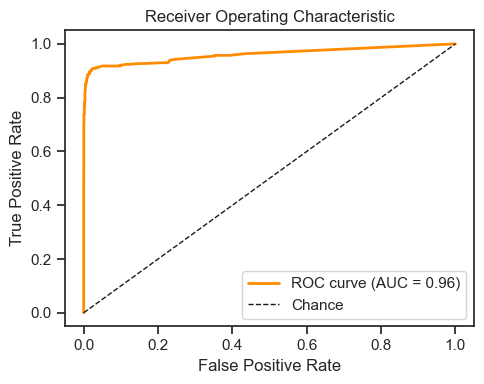

In [27]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

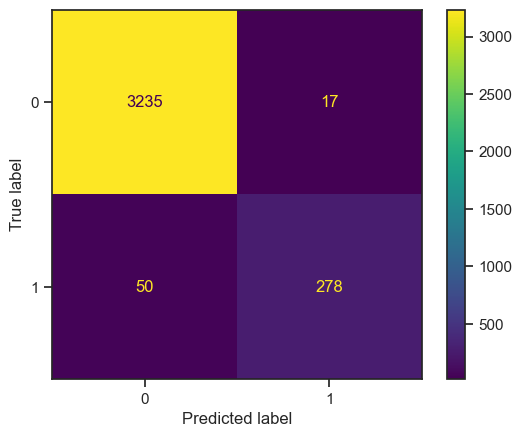

In [28]:
cm = confusion_matrix(y_test, y_pred)
fig = ConfusionMatrixDisplay(cm)
fig.plot()

In [29]:
print(f'Log  Loss: {log_loss(y_test, y_pred_proba):.4f}')

Log  Loss: 0.1773


### Hyperparameter Tuning with Random Search and CV

The Cross Validation concept allow us to work with 3 sets: training, validation and testing. That's why we use only the training set to find the best hyperparameters. So, when we finish this process, we can evaluate the model with the test set that was never used before.

Here, we opt for Randomized Search to explore a wider range of hyperparameters. Also, it's computationally more efficient, and it has been proven to statistically paired or even better than Grid Search in some scenarios (Bergstra and Bengio, 2012).

In [30]:
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(5, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'max_samples': uniform(0.7, 0.3)  # Bootstrap sample size (0.7 to 1.0)
}

In [31]:
rf_model_cv = RandomForestClassifier(class_weight='balanced', random_state=42)
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scorer = make_scorer(f1_score, pos_label=1)

random_search = RandomizedSearchCV(
    estimator=rf_model_cv,
    param_distributions=param_dist,
    n_iter=10,
    scoring=scorer,
    cv=kfolds,
)

In [32]:
random_search.fit(X_train, y_train)

,estimator,RandomForestC...ndom_state=42)
,param_distributions,"{'max_depth': <scipy.stats....t 0x140bf64e0>, 'max_features': ['sqrt', 'log2', ...], 'max_samples': <scipy.stats....t 0x140bdc2c0>, 'min_samples_leaf': <scipy.stats....t 0x140c4b200>, ...}"
,n_iter,10
,scoring,"make_scorer(f..., pos_label=1)"
,n_jobs,None
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [33]:
"""
Best params: {'max_depth': 28, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 218}
Best cross-validated F1 score: 0.8742
"""
best_model = random_search.best_estimator_
best_params = random_search.best_params_

print(f'Best params: {best_params}')
best_score = random_search.best_score_
print(f'Best cross-validated F1 score: {best_score:.4f}')

Best params: {'max_depth': 19, 'max_features': 'sqrt', 'max_samples': np.float64(0.9727031972778726), 'min_samples_leaf': 1, 'min_samples_split': 11, 'n_estimators': 138}
Best cross-validated F1 score: 0.8714


In [34]:
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3252
           1       0.90      0.88      0.89       328

    accuracy                           0.98      3580
   macro avg       0.95      0.93      0.94      3580
weighted avg       0.98      0.98      0.98      3580



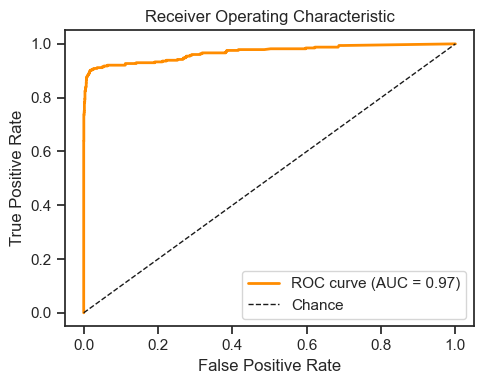

In [35]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

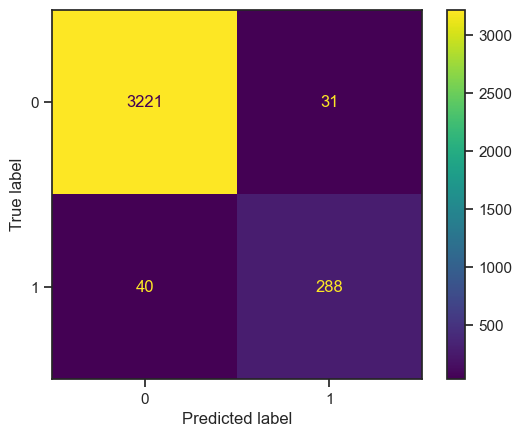

In [36]:
cm = confusion_matrix(y_test, y_pred)
fig = ConfusionMatrixDisplay(cm)
fig.plot()

In [37]:
# Export the best model
import joblib
joblib.dump(best_model, '../models/random_forest_best_model.pkl')

['../models/random_forest_best_model.pkl']